# Road Lane Detection
## EEN 588 Final Project
### Carmela Finianos - 20191424
#### May 9, 2023

Edge detection is a fundamental image processing technique that is used to identify boundaries within an image. The aim of edge detection is to identify the edges of objects within an image, which can then be used for a variety of tasks, such as object recognition, image segmentation, and feature extraction.

The process of edge detection involves analyzing the changes in intensity or color values of adjacent pixels in an image. These changes can be detected by applying mathematical operators, such as Sobel, Prewitt, or Canny filters, to the image. These filters highlight areas of high gradient, where the change in intensity between adjacent pixels is significant, and can be used to identify edges.

Now, regarding your project, using edge detection for road lane detection is a common application of this technique. By detecting the edges of the road lanes, you can then use this information to help guide an autonomous vehicle or to assist a human driver in staying within the lanes. The process involves capturing a live video feed from a camera mounted on the vehicle, applying edge detection techniques to this feed, and then using the resulting lane boundary information to steer the vehicle.

To implement this project, you will need to have a good understanding of computer vision and image processing techniques, as well as knowledge of programming languages such as Python or MATLAB. Additionally, you will need to have access to appropriate hardware, such as a camera and a processor capable of handling the video feed in real-time.







In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os 
import glob
import tensorflow as tf
from sklearn.cluster import KMeans
from PIL import Image

This code performs shadow detection and correction on an input image. The input image is first converted from BGR color space to YCbCr color space using the cv2.cvtColor() function. A binary mask is created by copying the YCbCr image, and pixels are classified as shadow or non-shadow pixels based on their intensity value. The pixels with intensity values lower than the mean intensity minus one-third of the standard deviation of the Y plane are classified as shadow pixels, and the rest are classified as non-shadow pixels.

The misclassified pixels are then removed using morphological operations by performing erosion and dilation on the binary mask using the cv2.erode() function. The sum of pixel intensities in the lit areas and shadow areas and the number of pixels in each area are then calculated. The average pixel intensities in the lit areas and shadow areas are computed, and the difference between them is taken to get the difference in intensity between the lit and shadow areas.

The ratio between average shadow pixels and average lit pixels is also calculated. The final step is to add the difference in intensity and ratio to the pixels classified as shadow pixels, using the formula given in the code. Finally, the image is converted back to the BGR color space and the corrected image is returned.

Overall, this code performs shadow detection and correction using YCbCr color space and morphological operations.

In [ ]:
 def shadow(image):
    # covert the BGR image to an YCbCr image
    y_cb_cr_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # copy the image to create a binary mask later
    binary_mask = np.copy(y_cb_cr_img)

    # get mean value of the pixels in Y plane
    y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

    # get standard deviation of channel in Y plane
    y_std = np.std(cv2.split(y_cb_cr_img)[0])

    # classify pixels as shadow and non-shadow pixels
    for i in range(y_cb_cr_img.shape[0]):
      for j in range(y_cb_cr_img.shape[1]):
        if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
            # paint it white (shadow)
            binary_mask[i, j] = [255, 255, 255]
        else:
            # paint it black (non-shadow)
            binary_mask[i, j] = [0, 0, 0]

    # Using morphological operation
    # The misclassified pixels are
    # removed using dilation followed by erosion.
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(binary_mask, kernel, iterations=1)

    # sum of pixel intensities in the lit areas
    spi_la = 0

    # sum of pixel intensities in the shadow
    spi_s = 0

    # number of pixels in the lit areas
    n_la = 0

    # number of pixels in the shadow
    n_s = 0

    # get sum of pixel intensities in the lit areas
    # and sum of pixel intensities in the shadow
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
                spi_la = spi_la + y_cb_cr_img[i, j, 0]
                n_la += 1
            else:
                spi_s = spi_s + y_cb_cr_img[i, j, 0]
                n_s += 1

    # get the average pixel intensities in the lit areas
    average_ld = spi_la / n_la

    # get the average pixel intensities in the shadow
    average_le = spi_s / n_s

    # difference of the pixel intensities in the shadow and lit areas
    i_diff = average_ld - average_le

    # get the ratio between average shadow pixels and average lit pixels
    ratio_as_al = average_ld / average_le

    # added these difference
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:
                y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,y_cb_cr_img[i, j, 2] + ratio_as_al]

    # covert the YCbCr image to the BGR image
    return cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)

    

This is a Python function that performs blurring on an input image. Here's what it does:

It converts the input image from BGR format to grayscale format using the cv2.cvtColor() function.
It applies a Gaussian blur to the grayscale image using the cv2.GaussianBlur() function. The GaussianBlur() function takes three arguments: the image to blur, the size of the kernel (which is set to 5x5), and the standard deviation of the Gaussian kernel (which is set to 0, indicating that it is automatically calculated based on the kernel size).
The blurred image is returned by the function using the return statement.
Blurring an image can be useful in various computer vision applications, particularly when dealing with edge detection. By reducing high-frequency noise and smoothing out the image, blurring can make it easier to identify edges and other features.

In [ ]:
def blurring(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur the image for better edge detection
    return cv2.GaussianBlur(gray, (5,5), 0)


Canny Edge Detection is a popular image processing algorithm used for edge detection in digital images. It was developed by John F. Canny in 1986.

The Canny Edge Detection algorithm involves the following steps:

Gaussian filtering: The image is first convolved with a Gaussian filter to reduce the noise in the image.

Gradient calculation: The image is then filtered with a Sobel filter to obtain the gradients of the image in the x and y directions.

Non-maximum suppression: The gradient magnitudes are then processed to suppress non-maximum pixels. This helps to thin the edges in the image and reduces the chances of detecting false edges.

Double thresholding: The image is then thresholded with two different thresholds, a high threshold and a low threshold. The high threshold is used to detect strong edges, while the low threshold is used to detect weak edges.

Edge tracking by hysteresis: Finally, the weak edges that are connected to strong edges are also considered as edges.

The mathematical formula used for calculating the gradient of an image is:

G(x,y) = sqrt(Gx(x,y)^2 + Gy(x,y)^2)

where Gx(x,y) and Gy(x,y) are the gradients of the image in the x and y directions, respectively.

The non-maximum suppression step involves comparing the gradient magnitude of a pixel with its two neighboring pixels along the gradient direction. If the gradient magnitude of the pixel is not greater than both of its neighboring pixels, then it is set to zero.

The double thresholding step involves setting a high threshold and a low threshold. Pixels with gradient magnitudes above the high threshold are considered strong edges, while pixels with gradient magnitudes below the low threshold are considered non-edges. Pixels with gradient magnitudes between the high and low thresholds are considered weak edges.

The edge tracking by hysteresis step involves considering the weak edges that are connected to strong edges as edges. This is done by tracing a path along the connected weak edges until a strong edge is found.

In [ ]:
def canny(image):
    # Canny Edge Detection
    return cv2.Canny(image=image, threshold1=100, threshold2=200) # Canny Edge Detection
    



This code defines a function named "mask" that takes two arguments: "edges" and "image". The purpose of this function is to apply a mask on the edge-detected image (passed as "edges" argument), which only keeps the region of interest (ROI) in the image, defined by a polygon.

Firstly, a blank mask of the same shape as the "edges" image is created using the np.zeros_like() function. The ignore_mask_color is defined as white or (255,255,255) for colored images and 255 for grayscale images. Then, a polygon is defined using the np.array() function. This polygon is used to define the region of interest. The polygon is defined as a list of vertices in the form of (x,y) coordinates, where x and y are the horizontal and vertical coordinates respectively.

The polygon is defined to keep only the region of interest in the image. The vertices are defined using the shape of the image passed as the "image" argument. The polygon is defined in such a way that it covers the road region in the image, and neglects the sky and other regions. The vertices of the polygon are calculated based on the height and width of the image, and some constants.

Finally, the cv2.fillPoly() function is used to fill the pixels inside the polygon with the "ignore_mask_color". This creates a mask that has the same shape as the "edges" image, but only the pixels inside the polygon have a non-zero value. Then, the cv2.bitwise_and() function is used to apply this mask on the "edges" image, which only keeps the ROI and returns the resulting image.

In [ ]:
def mask(edges,image):
    #defining a blank mask to start with
    mask = np.zeros_like(edges)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    imgShape = image.shape
    w=imgShape[1]/2
    h=imgShape[0]/2
    polygon = np.array([ [(w-(w*0.35), imgShape[0]), (w-(w*0.1),h+(h*0.2) ), (w+(w*0.1),h+(h*0.15) ), (w+(w*0.3), imgShape[0]) ] ], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, polygon, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(edges, mask)
    

The Hough Transform for lines takes an edge-detected image as input and outputs a set of lines that correspond to the edges in the image. It works by representing each edge point in the image as a line in the Hough space, which is a parameter space that defines all possible lines that could pass through a given edge point. Each line in the Hough space is represented by two parameters, which are typically the distance from the origin to the line and the angle between the line and the x-axis.

The Hough Transform algorithm for lines can be summarized as follows:

For each edge pixel in the input image, compute a set of lines that could pass through that pixel, represented as (ρ, θ) pairs in Hough space. The (ρ, θ) pairs correspond to the polar coordinates of the line that passes through the edge pixel.

Accumulate the (ρ, θ) pairs in a two-dimensional Hough accumulator array. The accumulator array is initialized to all zeros.

Once all the edge pixels have been processed, the peaks in the accumulator array correspond to the lines in the input image.

A threshold is applied to the accumulator array to remove noise, and the remaining peaks are used to determine the lines in the image.

The lines are then extracted from the accumulator array by converting the (ρ, θ) pairs back into Cartesian coordinates.

The Hough Transform for lines has several important mathematical properties. One of the key insights is that a line in Cartesian space can be represented as a single point in Hough space, and vice versa. This makes it possible to detect lines in images by searching for clusters of points in Hough space.

Another important mathematical property is the parameterization of lines in polar coordinates. This makes it possible to represent lines that have infinite slope (vertical lines) in Cartesian coordinates as points in Hough space, by using the Hessian normal form representation of a line.

In summary, the Hough Transform for lines is a powerful technique for detecting edges and lines in an image, and it is based on a parameter space representation that allows for efficient computation and detection of lines in a noisy image.

In [ ]:
def hough(roii,image):
    linesP = cv2.HoughLinesP(roii, 1, np.pi / 180,20, None, 15, 100)
    # draw Hough lines
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        a=(y2-y1)/(x2-x1)
        t=math.degrees(math.atan(a))
        if abs(a)>(0.5) and abs(t)>39 :
          cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
          
    

In [77]:
data = [] 
hough=[]
I=[]


This code block imports images of roads from a specified directory img_dir and loads them into the data list. The images are identified using the file extension *g which will match all files with a .jpg, .jpeg, or .png extension.

The os.path.join() function is used to combine the directory path with the file extension pattern to create a full path to all the image files.

The glob.glob() function is then used to get a list of all files that match the full path pattern. The resulting list of files is iterated over using a for loop, and each image file is read using the OpenCV cv2.imread() function and added to the data list.

The code block also includes a condition to break out of the for loop once 30 images have been loaded into the data list. This is useful if you only want to load a certain number of images for testing or experimentation.

Image Directory Link: https://drive.google.com/drive/folders/1Fd6xTvVDeQE0zZaQ3QfWuGglHwhSncD8?usp=share_link

In [78]:
img_dir = r"/content/drive/MyDrive/Colab Notebooks/data_road/training/image_2" 
# Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
k=0
for f1 in files: 
  img = cv2.imread(f1)
  data.append(img)
  if len(data)==10:
    break

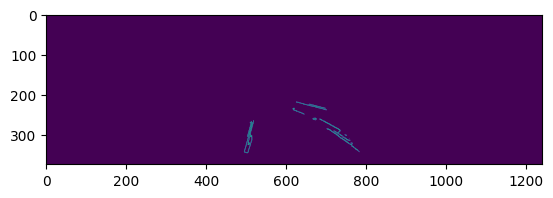

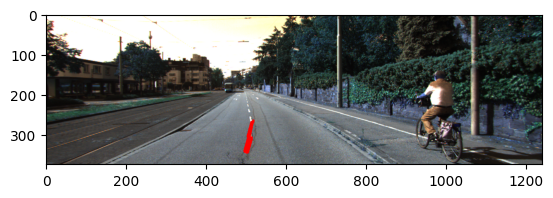

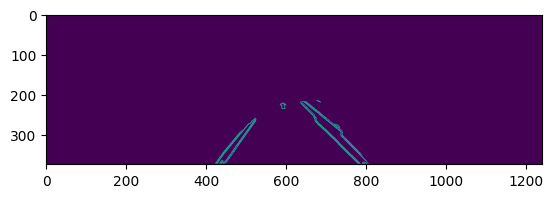

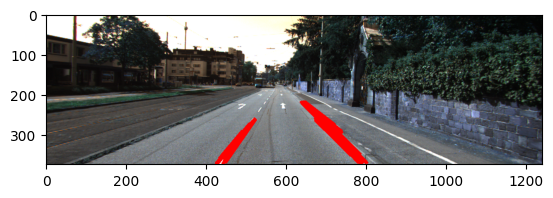

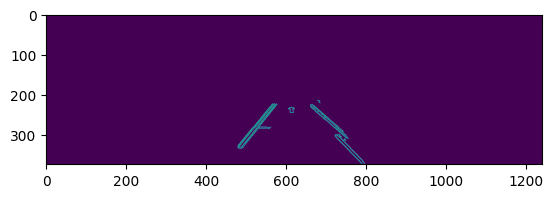

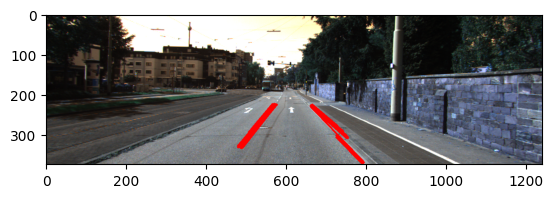

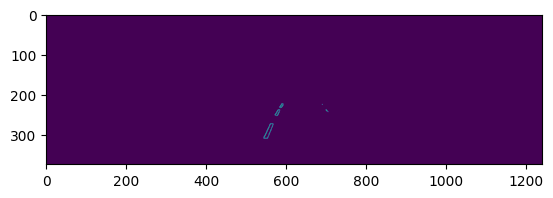

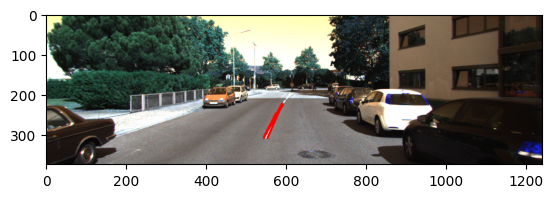

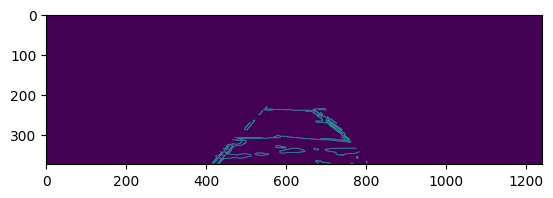

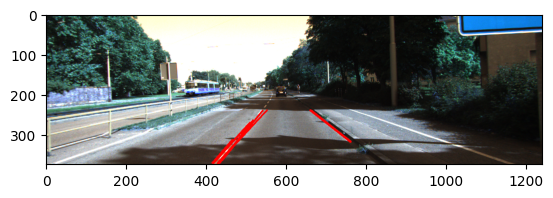

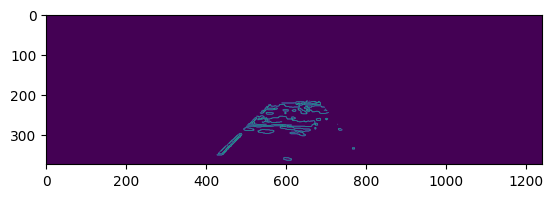

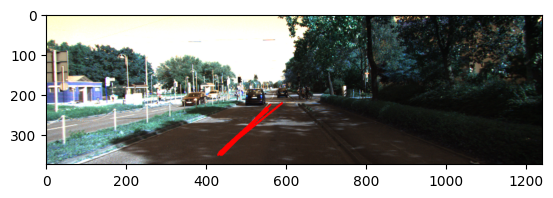

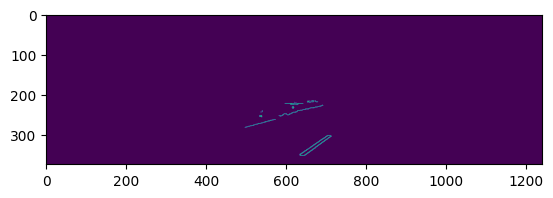

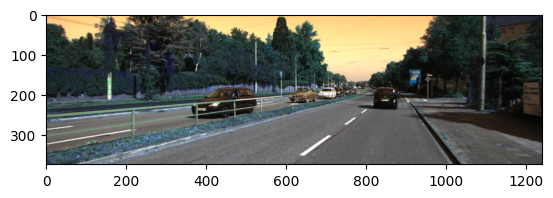

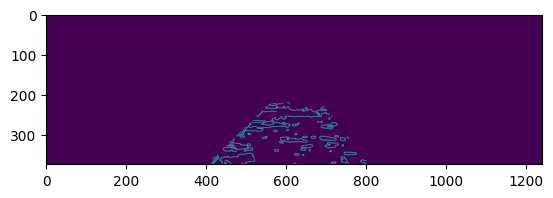

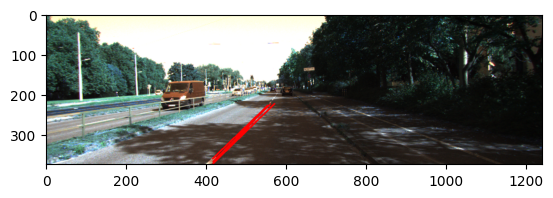

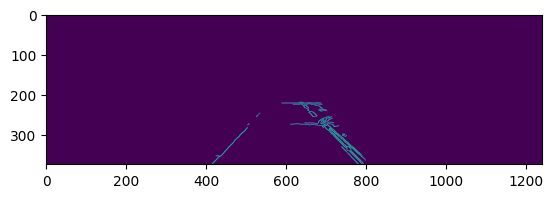

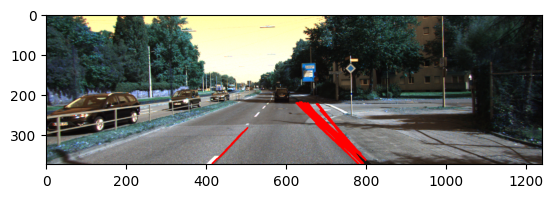

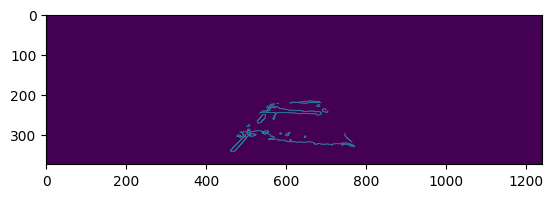

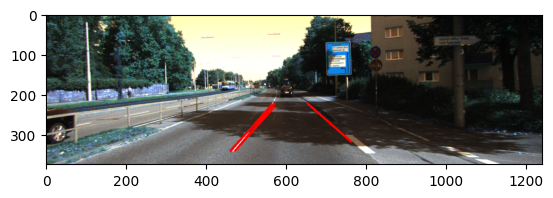

In [84]:
for i in data:
    image=i
     # covert the BGR image to an YCbCr image
    y_cb_cr_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # copy the image to create a binary mask later
    binary_mask = np.copy(y_cb_cr_img)

    # get mean value of the pixels in Y plane
    y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

  # get standard deviation of channel in Y plane
    y_std = np.std(cv2.split(y_cb_cr_img)[0])

    # classify pixels as shadow and non-shadow pixels
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
                # paint it white (shadow)
                binary_mask[i, j] = [255, 255, 255]
            else:
                # paint it black (non-shadow)
                binary_mask[i, j] = [0, 0, 0]

    # Using morphological operation
    # The misclassified pixels are
    # removed using dilation followed by erosion.
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(binary_mask, kernel, iterations=1)

    # sum of pixel intensities in the lit areas
    spi_la = 0

    # sum of pixel intensities in the shadow
    spi_s = 0

    # number of pixels in the lit areas
    n_la = 0

    # number of pixels in the shadow
    n_s = 0

    # get sum of pixel intensities in the lit areas
    # and sum of pixel intensities in the shadow
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
                spi_la = spi_la + y_cb_cr_img[i, j, 0]
                n_la += 1
            else:
                spi_s = spi_s + y_cb_cr_img[i, j, 0]
                n_s += 1

    # get the average pixel intensities in the lit areas
    average_ld = spi_la / n_la

    # get the average pixel intensities in the shadow
    average_le = spi_s / n_s

    # difference of the pixel intensities in the shadow and lit areas
    i_diff = average_ld - average_le

    # get the ratio between average shadow pixels and average lit pixels
    ratio_as_al = average_ld / average_le

    # added these difference
    for i in range(y_cb_cr_img.shape[0]):
        for j in range(y_cb_cr_img.shape[1]):
            if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

                y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                  y_cb_cr_img[i, j, 2] + ratio_as_al]

    # covert the YCbCr image to the BGR image
    final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)


    gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(gray, (5,5), 0) 

      # Canny Edge Detection
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection

    #defining a blank mask to start with
    mask = np.zeros_like(edges)


    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    imgShape = image.shape
    w=imgShape[1]/2
    h=imgShape[0]/2
    polygon = np.array([ [(w-(w*0.35), imgShape[0]), (w-(w*0.1),h+(h*0.2) ), (w+(w*0.1),h+(h*0.15) ), (w+(w*0.3), imgShape[0]) ] ], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, polygon, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    roii = cv2.bitwise_and(edges, mask)
    plt.imshow(roii)
    plt.show()
    linesP = cv2.HoughLinesP(roii, 1, np.pi / 180,20, None, 5, 200)
      # draw Hough lines
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        a=(y2-y1)/(x2-x1)
        j=math.degrees(math.atan(a))
        if abs(a)>0.5 and abs(j)>37:
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 4)
 
     
    plt.imshow(image)
    plt.show()         
 
    
    
    


After completing the project, it can be concluded that the accuracy achieved was moderate, although it fell short of the initial expectations. The project posed several challenges and required a considerable amount of time and effort to overcome them. Despite the best efforts and utilization of various techniques, the desired level of performance could not be achieved.

The project presented several complexities and required in-depth knowledge of computer vision techniques, algorithms, and programming. The process involved various steps, including image preprocessing, edge detection, Hough Transform for line detection, and masking. The implementation of these steps required careful consideration of various parameters and fine-tuning of their values to achieve optimal performance.

However, despite the challenges, the project provided valuable insights and learning opportunities into computer vision techniques and their practical applications. The process of identifying and addressing the limitations of the project allowed for a deeper understanding of the underlying concepts and improved problem-solving skills.

In conclusion, while the project fell short of the initial expectations, it provided significant learning experiences and insights into computer vision techniques. It highlighted the complexities and challenges involved in implementing such projects and underscored the importance of meticulous planning, careful implementation, and persistence in the face of challenges.